# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

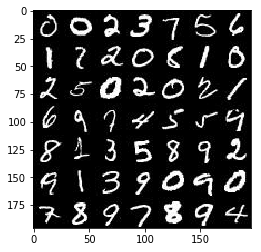

In [2]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
_ = pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

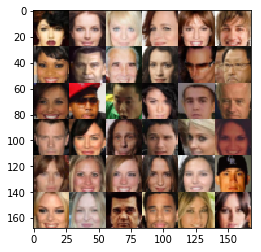

In [3]:
show_n_images = 42

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
_ = pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_img_placeholder = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real' )
    z_input_placeholder = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate_placeholder = tf.placeholder(tf.float32, name='learning_rate')
    return real_input_img_placeholder, z_input_placeholder, learning_rate_placeholder


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

#### Notes
Architecture inspired by this website [GAN by Example using Keras on Tensorflow Backend](https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0) 

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # See DCGAN -- Cell 10
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        dropout = 0.4
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1,dropout)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2,dropout)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3,dropout)
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        relu4 = tf.layers.dropout(relu4,dropout)
        # 4x4x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `image_channels` images.

In [20]:
def generator(z, image_channels, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param image_channels: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # See DCGAN -- Cell 9
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        dropout=0.4
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1,dropout)
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, (5,5), strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, (5,5), strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        
        x4 = tf.layers.conv2d_transpose(x3, 32, (5,5), strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        #print(x4.shape)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, image_channels, (5,5), strides=1, padding='same')
        #print(logits.shape)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, image_channels, is_train=True)`

In [21]:
import numpy as np

In [22]:
def model_loss(input_real, input_z, image_channels):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param image_channels: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # See DCGAN -- Cell 11
    g_model = generator(input_z, image_channels, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # See DCGAN -- Cell 12
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, image_channels, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param image_channels: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, image_channels, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, image_channels)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    # extract data shape
    # Similar steps as the ones made in class GAN -- DCGAN/Cell 13
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # TODO: Train Model
                # See DCGAN -- Cell 15
                
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z,
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9433... Generator Loss: 16.9274
Epoch 1/2... Discriminator Loss: 2.0063... Generator Loss: 3.5818
Epoch 1/2... Discriminator Loss: 1.2059... Generator Loss: 0.9927
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 1.7854
Epoch 1/2... Discriminator Loss: 3.2820... Generator Loss: 0.1084
Epoch 1/2... Discriminator Loss: 1.5523... Generator Loss: 1.3003
Epoch 1/2... Discriminator Loss: 2.1862... Generator Loss: 0.4779
Epoch 1/2... Discriminator Loss: 1.6783... Generator Loss: 0.5812
Epoch 1/2... Discriminator Loss: 1.5693... Generator Loss: 1.6712
Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 0.8451


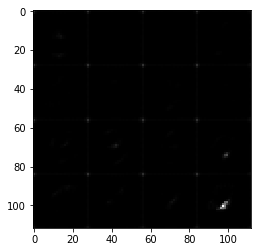

Epoch 1/2... Discriminator Loss: 1.1069... Generator Loss: 1.1602
Epoch 1/2... Discriminator Loss: 1.5856... Generator Loss: 0.7192
Epoch 1/2... Discriminator Loss: 1.5608... Generator Loss: 0.5301
Epoch 1/2... Discriminator Loss: 1.6352... Generator Loss: 0.5781
Epoch 1/2... Discriminator Loss: 1.4343... Generator Loss: 0.6438
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 0.7892
Epoch 1/2... Discriminator Loss: 1.8148... Generator Loss: 0.4148
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 1.0936
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.6838


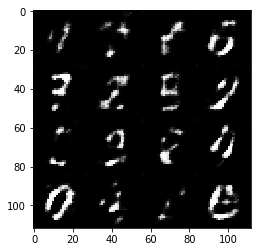

Epoch 1/2... Discriminator Loss: 1.3137... Generator Loss: 0.8023
Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 1.1470
Epoch 1/2... Discriminator Loss: 1.5909... Generator Loss: 0.6286
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 0.9517
Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 1.7132
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 1.0341
Epoch 1/2... Discriminator Loss: 1.4150... Generator Loss: 1.1276
Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 1.8535
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 0.9578
Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 0.8553


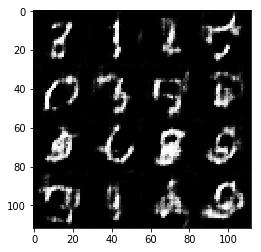

Epoch 1/2... Discriminator Loss: 1.3448... Generator Loss: 1.0725
Epoch 1/2... Discriminator Loss: 1.3135... Generator Loss: 1.1147
Epoch 1/2... Discriminator Loss: 1.4629... Generator Loss: 1.8367
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 2.2376
Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 1.1438
Epoch 1/2... Discriminator Loss: 1.2282... Generator Loss: 1.2114
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.9850
Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 0.8318
Epoch 1/2... Discriminator Loss: 1.4131... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.4697... Generator Loss: 0.6940


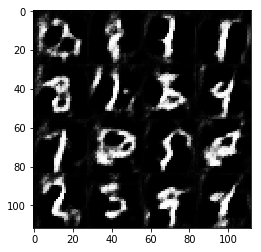

Epoch 1/2... Discriminator Loss: 1.3706... Generator Loss: 1.1674
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.9169
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.6281
Epoch 1/2... Discriminator Loss: 1.4393... Generator Loss: 0.6211
Epoch 1/2... Discriminator Loss: 1.5916... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.2833... Generator Loss: 1.1018
Epoch 1/2... Discriminator Loss: 1.2977... Generator Loss: 0.6905
Epoch 1/2... Discriminator Loss: 1.4260... Generator Loss: 1.3434
Epoch 1/2... Discriminator Loss: 1.4583... Generator Loss: 1.6294


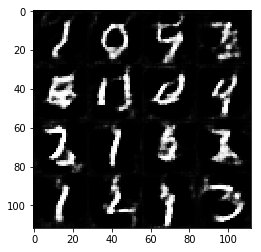

Epoch 1/2... Discriminator Loss: 1.2236... Generator Loss: 0.9180
Epoch 1/2... Discriminator Loss: 1.4459... Generator Loss: 1.4072
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 2.3817
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.3018... Generator Loss: 0.7379
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 1.2206
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.7391
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 1.1032
Epoch 1/2... Discriminator Loss: 1.1512... Generator Loss: 0.9938
Epoch 1/2... Discriminator Loss: 1.4777... Generator Loss: 0.6171


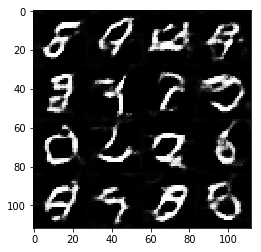

Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 1.0747
Epoch 1/2... Discriminator Loss: 1.3076... Generator Loss: 0.8188
Epoch 1/2... Discriminator Loss: 1.3475... Generator Loss: 0.6984
Epoch 1/2... Discriminator Loss: 1.5946... Generator Loss: 0.5627
Epoch 1/2... Discriminator Loss: 1.4886... Generator Loss: 0.5890
Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.6694
Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 0.9179
Epoch 1/2... Discriminator Loss: 1.5156... Generator Loss: 0.6464
Epoch 1/2... Discriminator Loss: 1.2426... Generator Loss: 0.9075
Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 1.8411


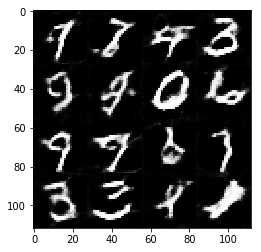

Epoch 1/2... Discriminator Loss: 1.4053... Generator Loss: 0.7136
Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 1.0839
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 1.7143
Epoch 1/2... Discriminator Loss: 1.4843... Generator Loss: 1.7780
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 2.1654
Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 1.1593
Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 0.5915
Epoch 1/2... Discriminator Loss: 1.6781... Generator Loss: 0.4523
Epoch 1/2... Discriminator Loss: 1.2583... Generator Loss: 0.8036
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 1.1146


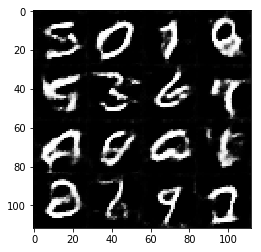

Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 0.9861... Generator Loss: 1.3894
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 1.0596
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 1.9163
Epoch 1/2... Discriminator Loss: 1.3930... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.5087... Generator Loss: 0.5604
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 1.1636
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 1.1400
Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 1.0742
Epoch 1/2... Discriminator Loss: 1.5123... Generator Loss: 0.6251


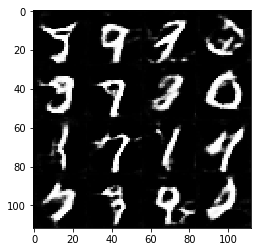

Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.7306
Epoch 1/2... Discriminator Loss: 1.6188... Generator Loss: 0.4712
Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 0.6553
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.8602
Epoch 1/2... Discriminator Loss: 1.1363... Generator Loss: 0.9364
Epoch 1/2... Discriminator Loss: 1.5203... Generator Loss: 1.6984
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 0.7050
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 0.9240
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.7302
Epoch 1/2... Discriminator Loss: 1.3423... Generator Loss: 1.5418


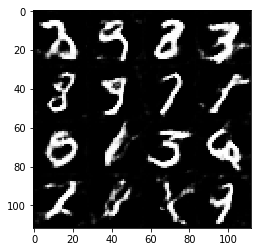

Epoch 1/2... Discriminator Loss: 1.4821... Generator Loss: 2.2661
Epoch 1/2... Discriminator Loss: 1.4288... Generator Loss: 0.6285
Epoch 1/2... Discriminator Loss: 1.7490... Generator Loss: 0.4318
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.7660
Epoch 1/2... Discriminator Loss: 1.3060... Generator Loss: 1.6003
Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.5731
Epoch 1/2... Discriminator Loss: 1.3982... Generator Loss: 1.1048
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 1.2568
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 1.0045


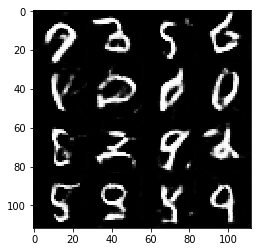

Epoch 1/2... Discriminator Loss: 1.4069... Generator Loss: 0.7139
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 2.1250
Epoch 1/2... Discriminator Loss: 1.4472... Generator Loss: 0.5809
Epoch 1/2... Discriminator Loss: 1.1658... Generator Loss: 1.1437
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 1.4845
Epoch 1/2... Discriminator Loss: 1.4276... Generator Loss: 0.6849
Epoch 1/2... Discriminator Loss: 1.1176... Generator Loss: 1.2809
Epoch 1/2... Discriminator Loss: 1.4017... Generator Loss: 0.7284
Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.6053


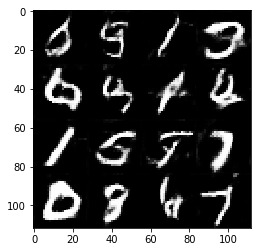

Epoch 1/2... Discriminator Loss: 1.8406... Generator Loss: 0.4005
Epoch 1/2... Discriminator Loss: 1.7264... Generator Loss: 0.4652
Epoch 1/2... Discriminator Loss: 1.0466... Generator Loss: 1.1899
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 1.1551
Epoch 1/2... Discriminator Loss: 1.5874... Generator Loss: 0.5299
Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.8577
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 1.0481
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 1.5713
Epoch 1/2... Discriminator Loss: 1.2145... Generator Loss: 0.8885
Epoch 1/2... Discriminator Loss: 1.7497... Generator Loss: 2.0577


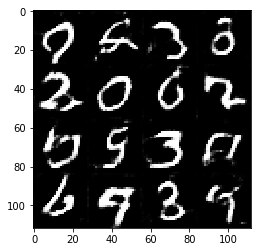

Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 1.1261
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.6861
Epoch 1/2... Discriminator Loss: 1.2960... Generator Loss: 2.0452
Epoch 1/2... Discriminator Loss: 1.6762... Generator Loss: 2.4300
Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 0.8171
Epoch 1/2... Discriminator Loss: 1.1383... Generator Loss: 1.6513
Epoch 1/2... Discriminator Loss: 1.2121... Generator Loss: 1.0007
Epoch 1/2... Discriminator Loss: 1.1972... Generator Loss: 0.9437
Epoch 1/2... Discriminator Loss: 1.3549... Generator Loss: 0.7024


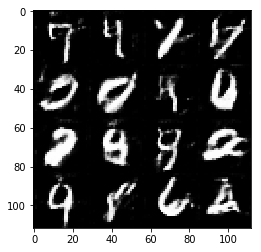

Epoch 1/2... Discriminator Loss: 1.4884... Generator Loss: 0.6235
Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.2696... Generator Loss: 0.7686
Epoch 1/2... Discriminator Loss: 1.1710... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 1.5400... Generator Loss: 0.5384
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 1.4829
Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 0.6829
Epoch 1/2... Discriminator Loss: 1.3108... Generator Loss: 1.0153
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 1.6674
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 1.3828


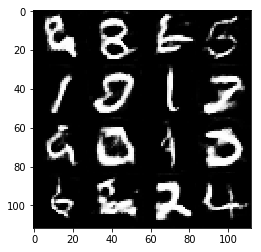

Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 1.0883
Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 0.9729
Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.6534
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 1.0256
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 0.7764
Epoch 1/2... Discriminator Loss: 1.3834... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.8456
Epoch 1/2... Discriminator Loss: 1.5831... Generator Loss: 0.5418
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 1.3603


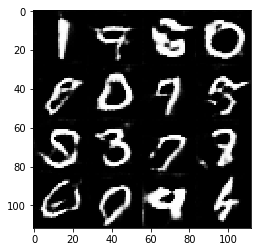

Epoch 1/2... Discriminator Loss: 1.0398... Generator Loss: 1.2976
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 1.4461... Generator Loss: 1.9144
Epoch 1/2... Discriminator Loss: 1.6276... Generator Loss: 0.5133
Epoch 1/2... Discriminator Loss: 1.2742... Generator Loss: 1.8701
Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.1081... Generator Loss: 1.1646
Epoch 1/2... Discriminator Loss: 1.2414... Generator Loss: 1.4850
Epoch 1/2... Discriminator Loss: 1.2391... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 2.1769


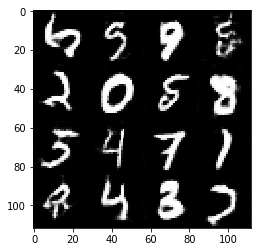

Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 1.0272
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 1.4223... Generator Loss: 0.6898
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 1.5124
Epoch 1/2... Discriminator Loss: 1.4184... Generator Loss: 0.6061
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 1.1140... Generator Loss: 1.0430
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 1.3015
Epoch 1/2... Discriminator Loss: 1.3739... Generator Loss: 0.7013
Epoch 1/2... Discriminator Loss: 2.0240... Generator Loss: 0.3191


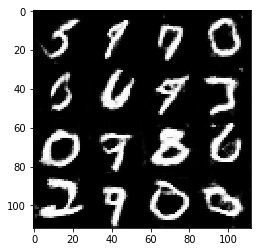

Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.8337
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.9233
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 1.2660
Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 1.6750
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 1.9482
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 1.3437
Epoch 2/2... Discriminator Loss: 1.2362... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.4769... Generator Loss: 0.5636
Epoch 2/2... Discriminator Loss: 1.0590... Generator Loss: 1.1166


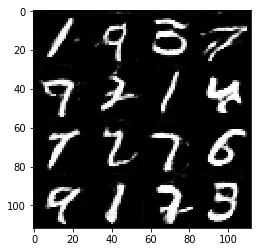

Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.1208... Generator Loss: 0.9916
Epoch 2/2... Discriminator Loss: 1.3875... Generator Loss: 0.6959
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 0.9202
Epoch 2/2... Discriminator Loss: 1.3502... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 1.8176
Epoch 2/2... Discriminator Loss: 1.1632... Generator Loss: 0.9807
Epoch 2/2... Discriminator Loss: 1.2794... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.0808... Generator Loss: 1.2104
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 1.7885


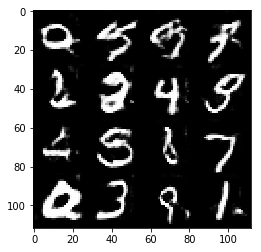

Epoch 2/2... Discriminator Loss: 1.2069... Generator Loss: 0.8341
Epoch 2/2... Discriminator Loss: 1.2058... Generator Loss: 0.8631
Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 1.3772
Epoch 2/2... Discriminator Loss: 1.4886... Generator Loss: 0.5770
Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 1.3145
Epoch 2/2... Discriminator Loss: 1.0608... Generator Loss: 1.2830
Epoch 2/2... Discriminator Loss: 1.0492... Generator Loss: 1.4350
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 0.6356
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 1.7768
Epoch 2/2... Discriminator Loss: 1.4497... Generator Loss: 0.6563


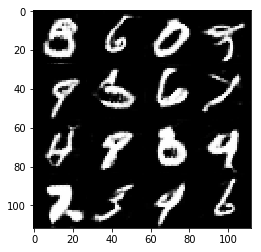

Epoch 2/2... Discriminator Loss: 1.2393... Generator Loss: 0.7996
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 1.0470
Epoch 2/2... Discriminator Loss: 1.3358... Generator Loss: 0.7827
Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 1.4721
Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 1.4794
Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 1.5323
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 1.5861
Epoch 2/2... Discriminator Loss: 1.0609... Generator Loss: 1.1832
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 2.2720
Epoch 2/2... Discriminator Loss: 1.3330... Generator Loss: 0.6891


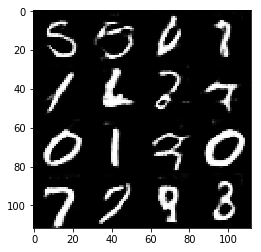

Epoch 2/2... Discriminator Loss: 1.1259... Generator Loss: 1.1300
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 0.9831
Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 0.8888
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 1.8978
Epoch 2/2... Discriminator Loss: 1.0398... Generator Loss: 1.6021
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 1.3890
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 1.5186
Epoch 2/2... Discriminator Loss: 1.6166... Generator Loss: 0.4860
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 0.9974
Epoch 2/2... Discriminator Loss: 1.0930... Generator Loss: 1.8149


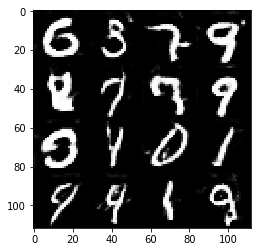

Epoch 2/2... Discriminator Loss: 1.6112... Generator Loss: 0.4812
Epoch 2/2... Discriminator Loss: 1.8006... Generator Loss: 0.3998
Epoch 2/2... Discriminator Loss: 0.9783... Generator Loss: 1.4929
Epoch 2/2... Discriminator Loss: 1.3670... Generator Loss: 0.7835
Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 1.2085
Epoch 2/2... Discriminator Loss: 1.0530... Generator Loss: 1.0243
Epoch 2/2... Discriminator Loss: 1.1761... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 1.9549
Epoch 2/2... Discriminator Loss: 1.1156... Generator Loss: 1.7860
Epoch 2/2... Discriminator Loss: 1.1124... Generator Loss: 1.0090


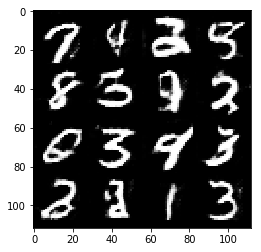

Epoch 2/2... Discriminator Loss: 1.1852... Generator Loss: 1.6313
Epoch 2/2... Discriminator Loss: 1.1921... Generator Loss: 0.8769
Epoch 2/2... Discriminator Loss: 1.4944... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 1.5674
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 1.0930
Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 1.7417
Epoch 2/2... Discriminator Loss: 1.0413... Generator Loss: 1.2722
Epoch 2/2... Discriminator Loss: 1.1348... Generator Loss: 1.0450
Epoch 2/2... Discriminator Loss: 1.3623... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 1.0889... Generator Loss: 1.1089


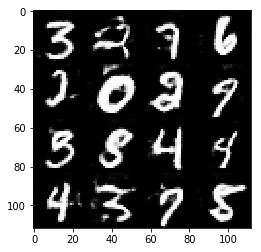

Epoch 2/2... Discriminator Loss: 1.4312... Generator Loss: 0.6458
Epoch 2/2... Discriminator Loss: 1.1031... Generator Loss: 1.5962
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.7382
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.0668... Generator Loss: 1.3699
Epoch 2/2... Discriminator Loss: 1.2496... Generator Loss: 0.7766
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 1.5355
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 1.6100... Generator Loss: 2.2227


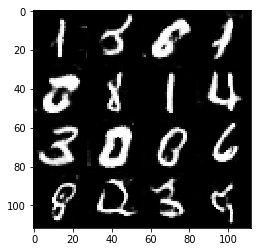

Epoch 2/2... Discriminator Loss: 1.3053... Generator Loss: 2.1006
Epoch 2/2... Discriminator Loss: 1.0505... Generator Loss: 1.8047
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 1.6108
Epoch 2/2... Discriminator Loss: 1.6240... Generator Loss: 2.1623
Epoch 2/2... Discriminator Loss: 1.0894... Generator Loss: 1.0496
Epoch 2/2... Discriminator Loss: 1.4325... Generator Loss: 0.5894
Epoch 2/2... Discriminator Loss: 1.0596... Generator Loss: 1.0561
Epoch 2/2... Discriminator Loss: 1.1845... Generator Loss: 0.8581
Epoch 2/2... Discriminator Loss: 1.0501... Generator Loss: 1.4418
Epoch 2/2... Discriminator Loss: 1.3741... Generator Loss: 0.6907


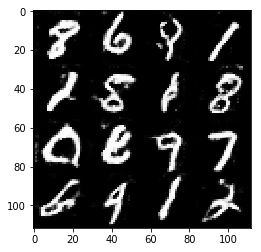

Epoch 2/2... Discriminator Loss: 1.1634... Generator Loss: 0.9550
Epoch 2/2... Discriminator Loss: 1.1697... Generator Loss: 0.9023
Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 1.2659
Epoch 2/2... Discriminator Loss: 1.0559... Generator Loss: 1.2911
Epoch 2/2... Discriminator Loss: 1.1402... Generator Loss: 0.9920
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 1.1950
Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 1.5880
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 1.1463
Epoch 2/2... Discriminator Loss: 1.1365... Generator Loss: 1.3848
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.7063


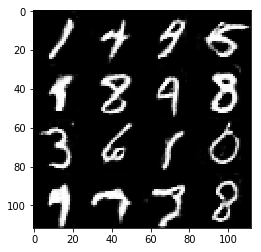

Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 1.0204
Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 1.0432
Epoch 2/2... Discriminator Loss: 1.1950... Generator Loss: 0.8545
Epoch 2/2... Discriminator Loss: 1.0786... Generator Loss: 1.1987
Epoch 2/2... Discriminator Loss: 1.6665... Generator Loss: 2.5435
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.8897
Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 1.3576
Epoch 2/2... Discriminator Loss: 1.1456... Generator Loss: 0.8840
Epoch 2/2... Discriminator Loss: 1.2844... Generator Loss: 0.7627
Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 1.0748


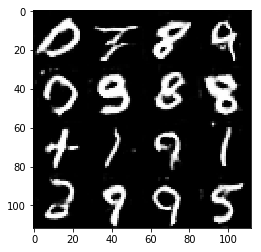

Epoch 2/2... Discriminator Loss: 1.1178... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 1.3066... Generator Loss: 0.7559
Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.7338
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 1.1390
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 1.1177... Generator Loss: 1.1246
Epoch 2/2... Discriminator Loss: 1.3980... Generator Loss: 0.6559
Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 1.4336
Epoch 2/2... Discriminator Loss: 1.3814... Generator Loss: 0.6625
Epoch 2/2... Discriminator Loss: 0.9733... Generator Loss: 1.6781


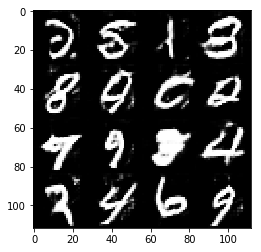

Epoch 2/2... Discriminator Loss: 1.2584... Generator Loss: 2.1955
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 1.2573
Epoch 2/2... Discriminator Loss: 0.9386... Generator Loss: 1.3268
Epoch 2/2... Discriminator Loss: 1.1247... Generator Loss: 2.4958
Epoch 2/2... Discriminator Loss: 1.0967... Generator Loss: 1.2533
Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 1.2836
Epoch 2/2... Discriminator Loss: 1.3601... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 1.0252... Generator Loss: 2.0846
Epoch 2/2... Discriminator Loss: 1.6274... Generator Loss: 0.4947
Epoch 2/2... Discriminator Loss: 1.1311... Generator Loss: 1.0373


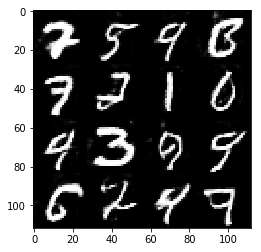

Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 0.9640
Epoch 2/2... Discriminator Loss: 0.9798... Generator Loss: 1.6010
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 1.4096
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 1.8543
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 1.8291
Epoch 2/2... Discriminator Loss: 1.2145... Generator Loss: 0.8773
Epoch 2/2... Discriminator Loss: 0.9569... Generator Loss: 1.4250
Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 0.8715
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.6827
Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 0.9181


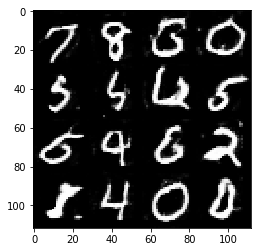

Epoch 2/2... Discriminator Loss: 1.3993... Generator Loss: 0.7746
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 1.4983
Epoch 2/2... Discriminator Loss: 1.0744... Generator Loss: 1.2513
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.6758
Epoch 2/2... Discriminator Loss: 1.2195... Generator Loss: 0.8290
Epoch 2/2... Discriminator Loss: 1.0846... Generator Loss: 1.3214
Epoch 2/2... Discriminator Loss: 1.0250... Generator Loss: 1.4151
Epoch 2/2... Discriminator Loss: 1.7462... Generator Loss: 0.5777
Epoch 2/2... Discriminator Loss: 1.8211... Generator Loss: 0.4231
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 1.4727


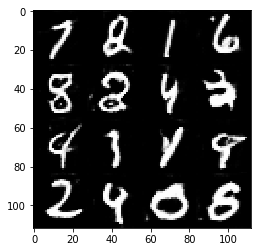

Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 1.4370
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 1.1163... Generator Loss: 1.1025
Epoch 2/2... Discriminator Loss: 1.1923... Generator Loss: 2.0179
Epoch 2/2... Discriminator Loss: 0.9475... Generator Loss: 1.6442
Epoch 2/2... Discriminator Loss: 1.5158... Generator Loss: 0.6068
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 1.1380
Epoch 2/2... Discriminator Loss: 1.0849... Generator Loss: 1.0432
Epoch 2/2... Discriminator Loss: 0.9943... Generator Loss: 1.3440
Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 1.4181


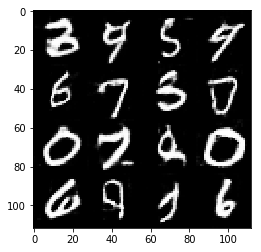

Epoch 2/2... Discriminator Loss: 1.8058... Generator Loss: 0.4838
Epoch 2/2... Discriminator Loss: 1.0449... Generator Loss: 1.0897
Epoch 2/2... Discriminator Loss: 1.1788... Generator Loss: 1.9642
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 1.0644
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 1.1198
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.6421
Epoch 2/2... Discriminator Loss: 1.5345... Generator Loss: 0.5341
Epoch 2/2... Discriminator Loss: 1.5700... Generator Loss: 1.7831
Epoch 2/2... Discriminator Loss: 1.0505... Generator Loss: 1.0988
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 1.3391


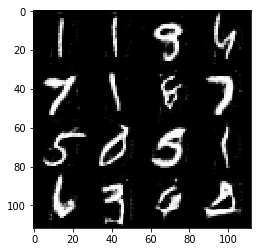

Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.7845
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.9834
Epoch 2/2... Discriminator Loss: 0.9435... Generator Loss: 1.3930
Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 0.6659
Epoch 2/2... Discriminator Loss: 1.6497... Generator Loss: 0.5233
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.3378
Epoch 2/2... Discriminator Loss: 1.9161... Generator Loss: 0.3398
Epoch 2/2... Discriminator Loss: 1.3889... Generator Loss: 0.6647
Epoch 2/2... Discriminator Loss: 1.6189... Generator Loss: 0.4541
Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 1.0935


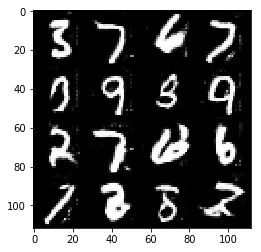

Epoch 2/2... Discriminator Loss: 0.9873... Generator Loss: 1.5111
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 1.3952
Epoch 2/2... Discriminator Loss: 1.0869... Generator Loss: 1.1506
Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 0.7330
Epoch 2/2... Discriminator Loss: 1.1186... Generator Loss: 1.0015
Epoch 2/2... Discriminator Loss: 1.1784... Generator Loss: 0.9439
Epoch 2/2... Discriminator Loss: 0.8516... Generator Loss: 1.7918
Epoch 2/2... Discriminator Loss: 1.2674... Generator Loss: 0.8742
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.8495
Epoch 2/2... Discriminator Loss: 0.9840... Generator Loss: 1.4026


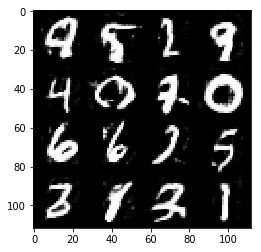

Epoch 2/2... Discriminator Loss: 0.9049... Generator Loss: 1.4036
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 1.0018
Epoch 2/2... Discriminator Loss: 1.4670... Generator Loss: 0.6591
Epoch 2/2... Discriminator Loss: 0.9992... Generator Loss: 1.6748
Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 1.6924


In [26]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 9.6876... Generator Loss: 0.0131
Epoch 1/1... Discriminator Loss: 2.4930... Generator Loss: 1.8402
Epoch 1/1... Discriminator Loss: 1.9554... Generator Loss: 2.4502
Epoch 1/1... Discriminator Loss: 1.7044... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 2.5709... Generator Loss: 0.2324
Epoch 1/1... Discriminator Loss: 2.3694... Generator Loss: 0.1071
Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 1.7293
Epoch 1/1... Discriminator Loss: 2.2872... Generator Loss: 0.1465
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 3.5192
Epoch 1/1... Discriminator Loss: 0.3412... Generator Loss: 1.5775


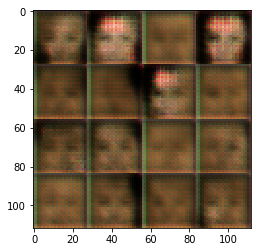

Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 2.6011
Epoch 1/1... Discriminator Loss: 2.0171... Generator Loss: 0.3016
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.1053
Epoch 1/1... Discriminator Loss: 1.6615... Generator Loss: 0.3710
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 1.2668
Epoch 1/1... Discriminator Loss: 2.2550... Generator Loss: 0.2015
Epoch 1/1... Discriminator Loss: 1.7296... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.6404


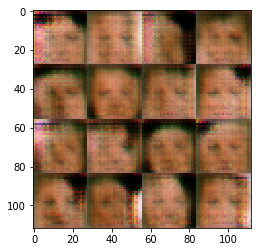

Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.4023
Epoch 1/1... Discriminator Loss: 2.1897... Generator Loss: 0.1615
Epoch 1/1... Discriminator Loss: 1.7303... Generator Loss: 0.3922
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.8698
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 1.5620... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.7219


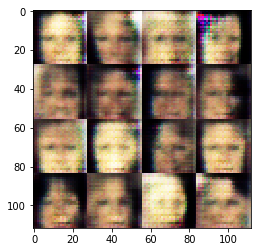

Epoch 1/1... Discriminator Loss: 1.9985... Generator Loss: 3.1722
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.6377... Generator Loss: 0.4101
Epoch 1/1... Discriminator Loss: 1.9420... Generator Loss: 0.3575
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 2.2359... Generator Loss: 0.1339
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.8988... Generator Loss: 0.2035


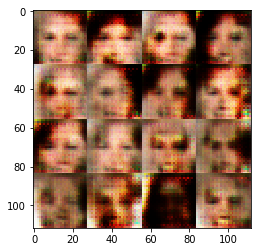

Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 2.8853... Generator Loss: 3.5863
Epoch 1/1... Discriminator Loss: 1.5528... Generator Loss: 0.2939
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.4695
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 1.5944
Epoch 1/1... Discriminator Loss: 3.6841... Generator Loss: 0.0243
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 1.3958
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.9458


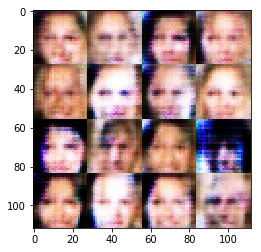

Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 2.2153... Generator Loss: 0.1468
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.5548
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.1811
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.3030
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.9666... Generator Loss: 0.3442
Epoch 1/1... Discriminator Loss: 2.0334... Generator Loss: 0.2453
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.9661


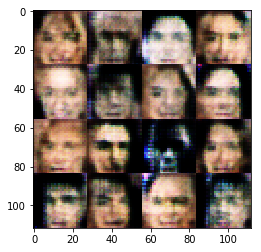

Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 1.7028
Epoch 1/1... Discriminator Loss: 2.1679... Generator Loss: 1.7575
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.6797... Generator Loss: 0.3086
Epoch 1/1... Discriminator Loss: 1.7228... Generator Loss: 0.3196
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 1.4069


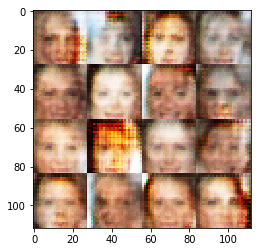

Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.6901... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 1.9758... Generator Loss: 0.2945
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 1.3827
Epoch 1/1... Discriminator Loss: 1.8436... Generator Loss: 0.3272
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.7315... Generator Loss: 0.2711
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.4262


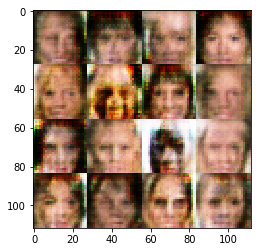

Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.3398
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.3190
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.3640
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.4372
Epoch 1/1... Discriminator Loss: 1.6396... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.7973... Generator Loss: 0.7306


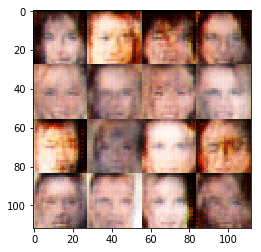

Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.3664
Epoch 1/1... Discriminator Loss: 1.8899... Generator Loss: 0.2986
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.7237... Generator Loss: 0.2936
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.4276
Epoch 1/1... Discriminator Loss: 1.5173... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.8197


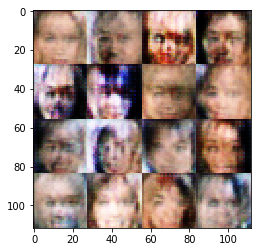

Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.4558
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.6057... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.4440
Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.3408
Epoch 1/1... Discriminator Loss: 1.8222... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.6617... Generator Loss: 0.7205


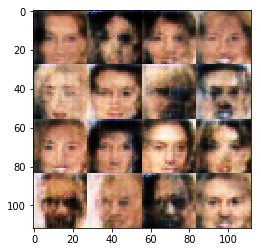

Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.5541... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.5492


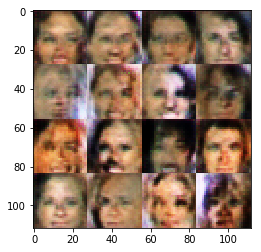

Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.7038... Generator Loss: 1.0598
Epoch 1/1... Discriminator Loss: 0.9191... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7715


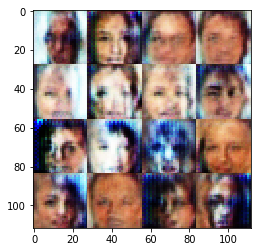

Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.7726


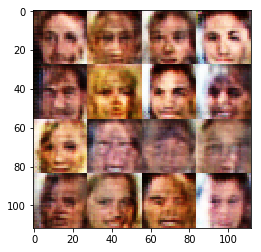

Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.7105... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 0.5215


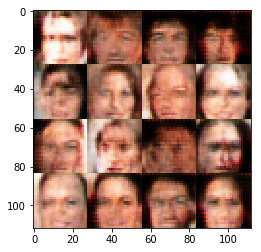

Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.7078... Generator Loss: 0.4011
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6352


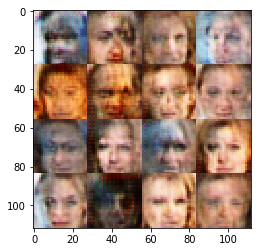

Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.6123... Generator Loss: 0.2902


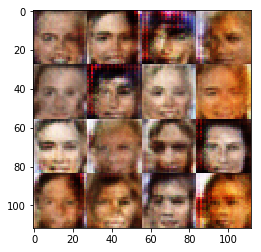

Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 2.0880... Generator Loss: 1.5388
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7057


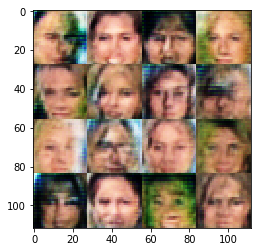

Epoch 1/1... Discriminator Loss: 2.1328... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.3652
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.6749


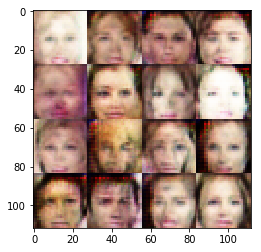

Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.6809... Generator Loss: 1.1004
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.5771
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.4008
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.4808


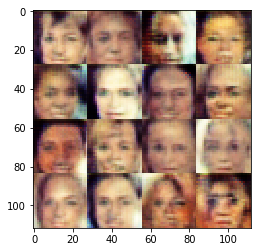

Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.4493
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6310


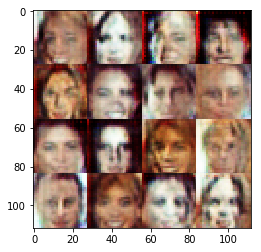

Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.6471... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.7552... Generator Loss: 0.2138
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.4098
Epoch 1/1... Discriminator Loss: 1.6982... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.6165... Generator Loss: 0.5029


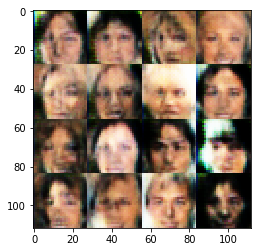

Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.9301


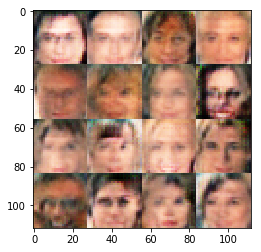

Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 1.6839... Generator Loss: 0.3904
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.7650


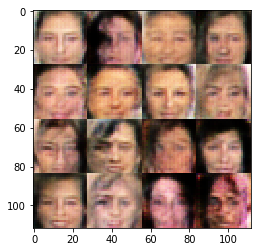

Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.6170... Generator Loss: 0.4276
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.3671
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.3150
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 1.0308


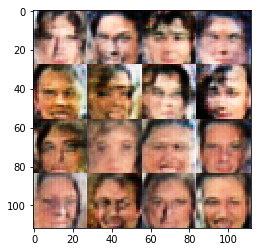

Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 1.1488
Epoch 1/1... Discriminator Loss: 1.7251... Generator Loss: 0.2622
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.3069
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7669


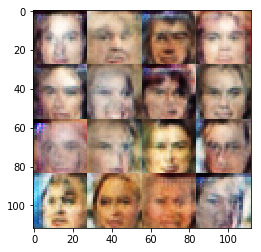

Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.3864
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.5973


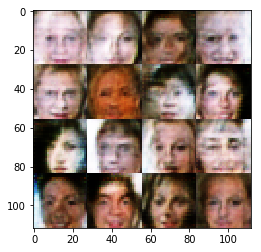

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.0054


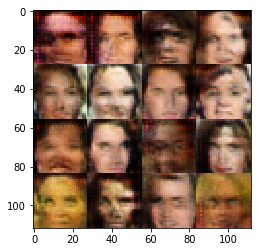

Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.4629
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.5430
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.5767


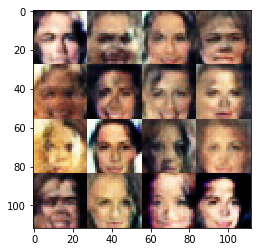

Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.5364


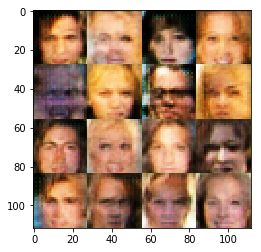

Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.4004
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.5934


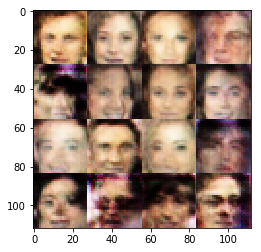

Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 0.2863
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.9536
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.7034


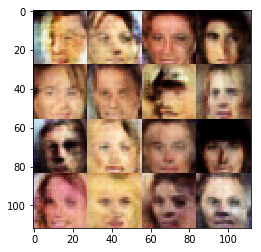

Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.4275
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.4680
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.4912
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.5921


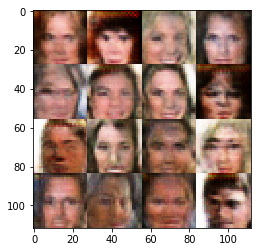

Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.3935
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.7949


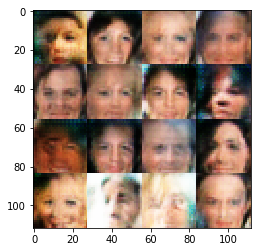

Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.4278
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.4168
Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.3125
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.5794


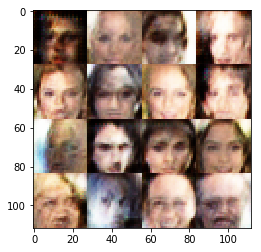

Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.5501


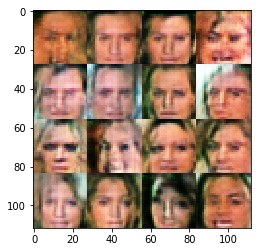

Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.5026


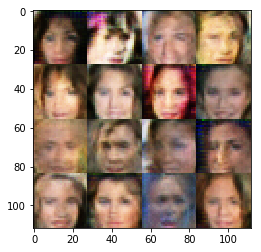

Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.7161... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.5101
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.4799


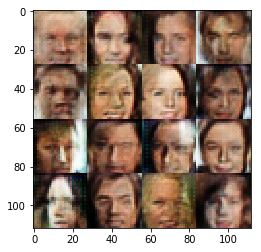

Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.5262


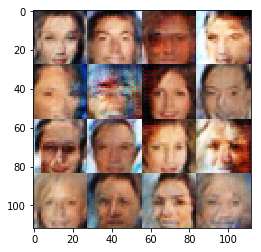

Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.7808... Generator Loss: 0.2912
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.6041


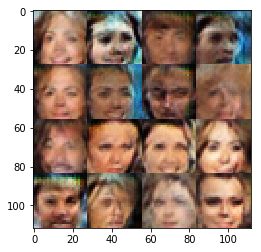

Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.4311
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.4277


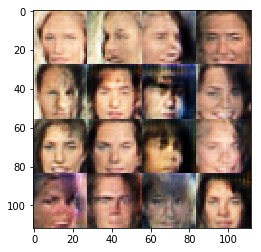

Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.5258
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.6068


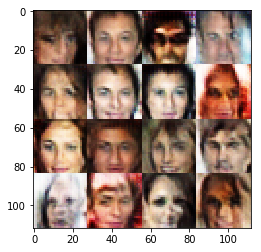

Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.5431
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.4306
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.5122


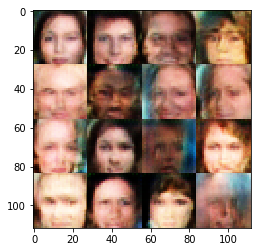

Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 1.6046... Generator Loss: 0.3842
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.1470... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.6224... Generator Loss: 0.2975
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7136


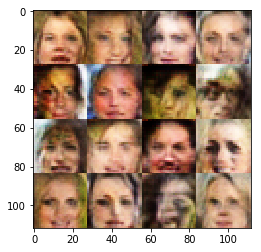

Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.4880
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.4330
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.6255


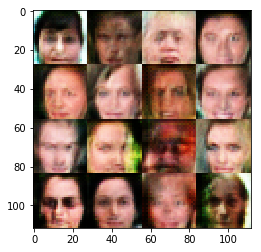

Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.5353


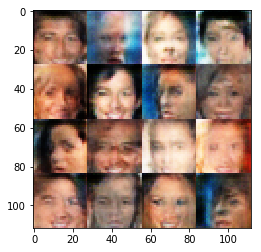

Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.4389
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.3539
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.5548
Epoch 1/1... Discriminator Loss: 1.3166... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.5228
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.8559


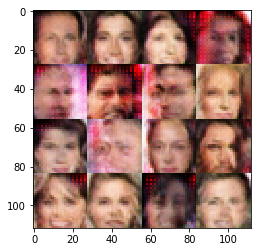

Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.5206
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8392


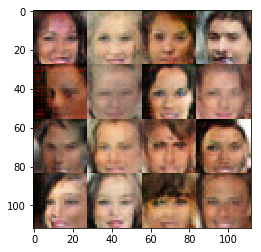

Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.4729
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.4327
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6065


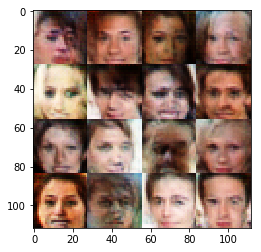

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 0.4760
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.5690


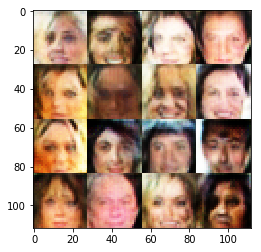

Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.5116
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.4762


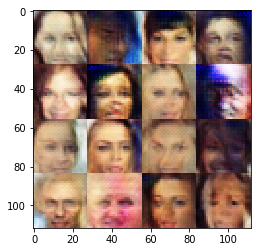

Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.6585


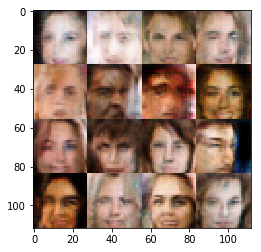

Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.5757


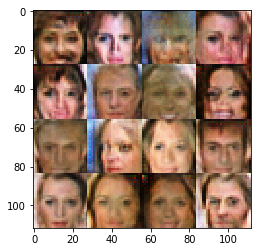

Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.5154


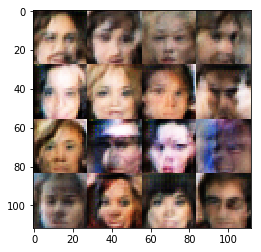

Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.5394


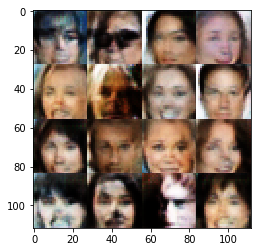

Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 0.4436
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.4645


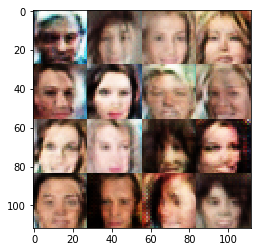

Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.6759


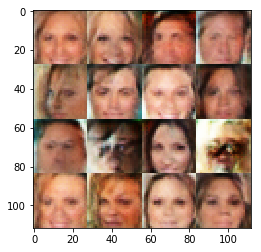

Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.4599
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6895


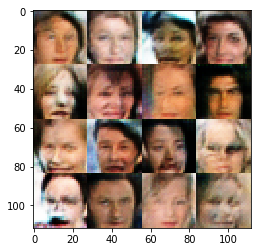

Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6734


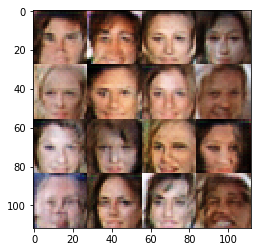

Epoch 1/1... Discriminator Loss: 1.5540... Generator Loss: 0.5361
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.4253
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.7751


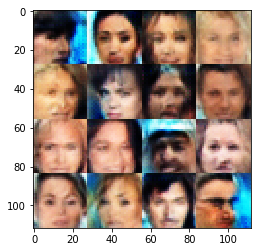

Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5530


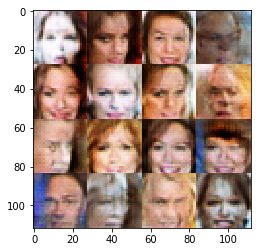

Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5081
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.5408


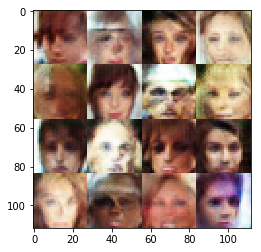

Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.4915
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 0.4777
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.6021... Generator Loss: 0.3543
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.5816


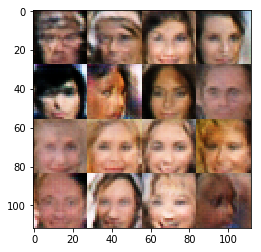

Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.6301


In [27]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.